In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nilearn.plotting import plot_anat, plot_epi, view_img
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)
from nilearn.image import mean_img, resample_img, resample_to_img

In [2]:
# Directory where your data set resides.
dataDir = '/data/testDS/mouse_main//bids/'

# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

In [3]:
epi_path = layout.get(suffix='bold', return_type='file', extensions=['nii.gz'])[0]
# T1 image from the layout object
imageT1_path = layout.get(suffix='T1w',
                       return_type='file')[0]
# Template
template_path = '/data/atlas/ambmc-c57bl6-model-symmet_v0.8-nii/ambmc-c57bl6-model-symmet_v0.8.nii'
labels_path = '/data/atlas/ambmc-c57bl6-label-cortex_v0.8-nii/ambmc-c57bl6-label-cortex_v0.8.nii'
labels_xml_path = '/data/atlas/AMBMC_cortex_labels.xml'
os.path.exists(template_path)

True

In [4]:
#load data for processing
labels = nib.load(labels_path)
epi = nib.load(epi_path)
epi_img = nib.as_closest_canonical(epi)
t1 = nib.load(imageT1_path)
t1_img = nib.as_closest_canonical(t1)
template = nib.load(template_path)
#brain_template = nib.load(brain_temp)
print('epi:\n', np.round(epi_img.affine,1), '\nshape: ', epi_img.shape, '\n\nt1: \n', np.round(t1_img.affine,1), '\nshape: ', t1_img.shape, '\n')
print('-'*43)#      
print('\ntemlate: \n', np.round(template.affine,1), '\nshape: ', template.shape, '\n\nlabels: \n', np.round(labels.affine,1), '\nshape: ', labels.shape)

epi:
 [[   4.7    0.     0.  -222.8]
 [   0.    15.     0.   -85.7]
 [   0.     0.     4.7 -110.1]
 [   0.     0.     0.     1. ]] 
shape:  (96, 12, 48, 120) 

t1: 
 [[   1.9    0.     0.  -238.4]
 [   0.     7.5    0.  -110.9]
 [   0.     0.     1.9 -119.3]
 [   0.     0.     0.     1. ]] 
shape:  (256, 30, 128) 

-------------------------------------------

temlate: 
 [[ 0.   0.   0.  -5.1]
 [ 0.   0.   0.  -9.8]
 [ 0.   0.   0.  -3.7]
 [ 0.   0.   0.   1. ]] 
shape:  (679, 1311, 499) 

labels: 
 [[ 0.   0.   0.  -5.1]
 [ 0.   0.   0.  -9.8]
 [ 0.   0.   0.  -3.7]
 [ 0.   0.   0.   1. ]] 
shape:  (679, 1311, 499)


In [14]:
t1.affine

array([[   1.875     ,   -0.        ,   -0.        , -238.44335938],
       [  -0.        ,   -0.        ,    7.5       , -110.91629791],
       [   0.        ,   -1.875     ,    0.        ,  118.79368591],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

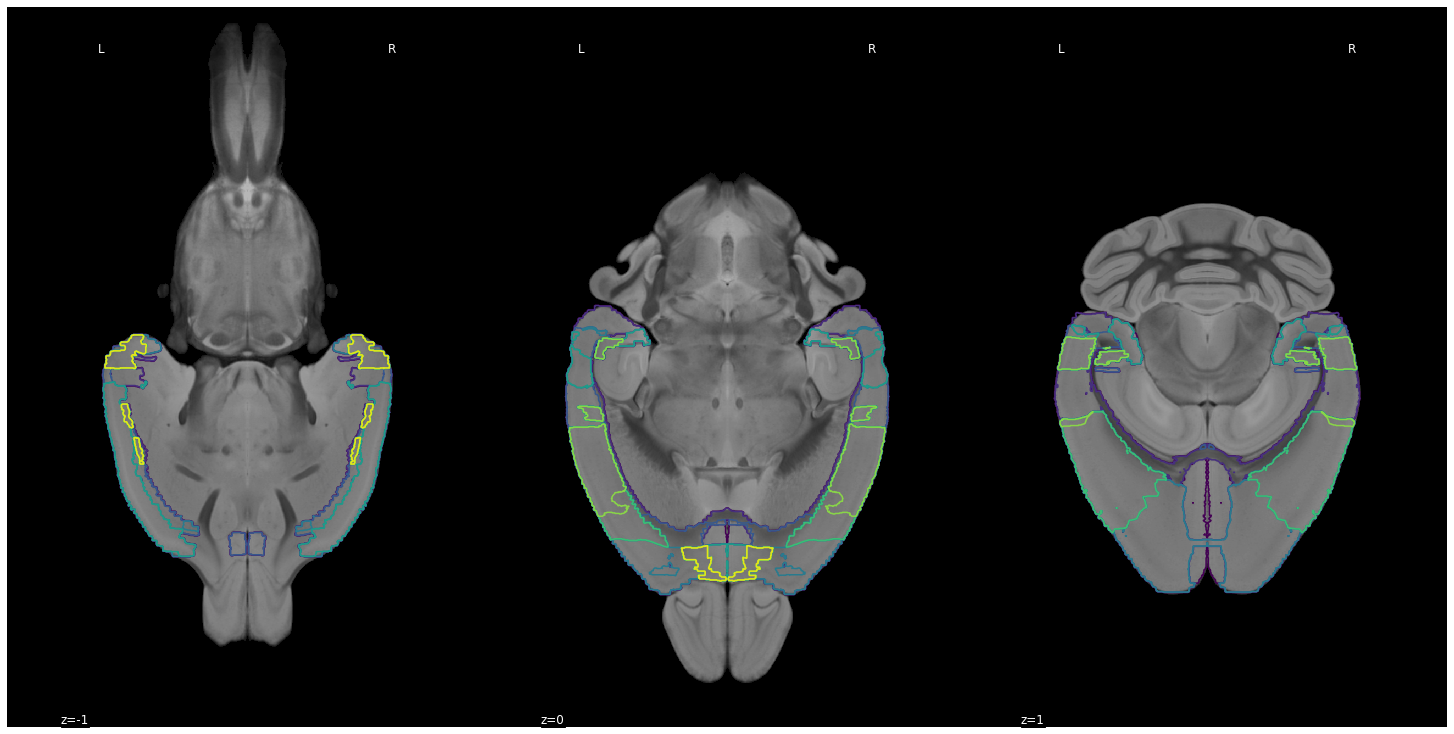

In [6]:
fig_1 = plt.figure(figsize=(20,10))
display = plot_anat(template, display_mode='z', cut_coords=3, figure=fig_1)
display.add_contours(labels)
#display.add_contours(mean_img(epi_img), alpha=1, linewidth=3.)
#display.add_contours(template, colors='g', linewidth=1.)

In [10]:
scale_transform = np.eye(4)
zooms = [template.shape[0]/t1_img.shape[0], template.shape[1]/(5*t1_img.shape[1]), 2*template.shape[0]/(t1_img.shape[0])]
np.fill_diagonal(scale_transform[:3], zooms)
print(zooms)

[2.65234375, 8.74, 5.3046875]


In [11]:
template_resamp = resample_img(template, target_affine=template.affine.dot(scale_transform), interpolation='nearest')
print(template_resamp.shape)
#np.round(template_resamp.affine,2)

labels_resamp = resample_img(labels, target_affine=labels.affine.dot(scale_transform), interpolation='nearest')
print(labels_resamp.shape)
np.round(labels_resamp.affine,2)

(257, 151, 95)
(257, 151, 95)


array([[ 0.04,  0.  ,  0.  , -5.08],
       [ 0.  ,  0.13,  0.  , -9.81],
       [ 0.  ,  0.  ,  0.08, -3.73],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [9]:
affine = np.eye(3) * 20
scaled_affine = np.eye(4)
scaled_affine[:3,:3] = affine
template_resamp.affine.dot(scaled_affine)

array([[ 0.79570311,  0.        ,  0.        , -5.07600021],
       [ 0.        ,  2.62199994,  0.        , -9.81449986],
       [ 0.        ,  0.        ,  0.79570311, -3.72600007],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [12]:
scaled_template_reorded = nib.Nifti1Image(template_resamp.dataobj[:,::-1,:], affine=template_resamp.affine)
labels_template_reorded = nib.Nifti1Image(labels_resamp.dataobj[:,::-1,:], affine=labels_resamp.affine)

In [13]:
nib.save(scaled_template_reorded, '/data/testDS/scaled_template.nii.gz')
nib.save(labels_template_reorded, '/data/testDS/scaled_labels.nii.gz')

In [12]:
scaled_template_reor = '/data/testDS/scaled_template.nii.gz'
scaled_labels_reor = '/data/testDS/scaled_labels.nii.gz'

In [13]:
scaled_template_reorded.affine

array([[   0.79570311,    0.        ,    0.        , -101.52000427],
       [   0.        ,    2.62199994,    0.        , -196.2899971 ],
       [   0.        ,    0.        ,    0.79570311,  -74.52000141],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [14]:
brain_path = '/data/testDS/mouse_2006/flash_brain.nii.gz'
brain = nib.load(brain_path)

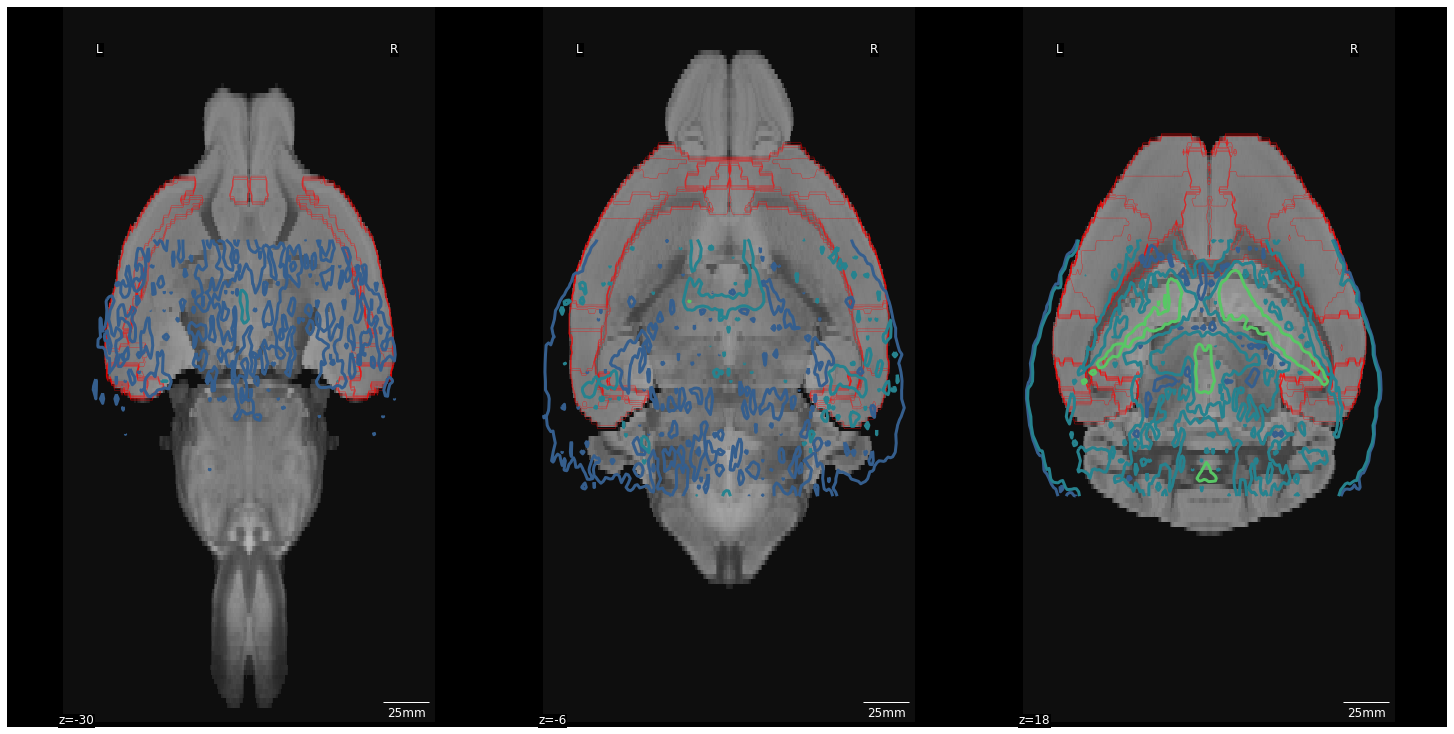

In [15]:
fig = plt.figure(figsize=(20,10))
dis = plot_anat(scaled_template_reor, cut_coords=3, display_mode='z', figure=fig)
dis.add_contours(scaled_labels_reor, linewidths=0.3, colors='r')
dis.add_contours(brain_path, linewidths=3., levels=[10,15,25, 35])
dis.annotate(scalebar=True, scale_size=25, scale_units='mm')

In [16]:
from nipype.interfaces.ants import RegistrationSynQuick
reg = RegistrationSynQuick()
reg.inputs.fixed_image = '/data/testDS/scaled_template.nii.gz'
reg.inputs.moving_image = brain_path
reg.inputs.num_threads = 6
reg.run()

201221-04:50:26,684 nipype.interface INFO:
	 stdout 2020-12-21T04:50:26.684676:
201221-04:50:26,686 nipype.interface INFO:
	 stdout 2020-12-21T04:50:26.684676:--------------------------------------------------------------------------------------
201221-04:50:26,687 nipype.interface INFO:
	 stdout 2020-12-21T04:50:26.684676: Mapping parameters
201221-04:50:26,687 nipype.interface INFO:
	 stdout 2020-12-21T04:50:26.684676:--------------------------------------------------------------------------------------
201221-04:50:26,688 nipype.interface INFO:
	 stdout 2020-12-21T04:50:26.684676: ANTSPATH is /usr/lib/ants
201221-04:50:26,689 nipype.interface INFO:
	 stdout 2020-12-21T04:50:26.684676:
201221-04:50:26,690 nipype.interface INFO:
	 stdout 2020-12-21T04:50:26.684676: Dimensionality:           3
201221-04:50:26,690 nipype.interface INFO:
	 stdout 2020-12-21T04:50:26.684676: Output name prefix:       transform
201221-04:50:26,691 nipype.interface INFO:
	 stdout 2020-12-21T04:50:26.684676:

In [17]:
outputs_reg = reg.aggregate_outputs()
print(outputs_reg)


forward_warp_field = /data/fMRI/transform1Warp.nii.gz
inverse_warp_field = /data/fMRI/transform1InverseWarp.nii.gz
inverse_warped_image = /data/fMRI/transformInverseWarped.nii.gz
out_matrix = /data/fMRI/transform0GenericAffine.mat
warped_image = /data/fMRI/transformWarped.nii.gz



In [18]:
warped_T1_path = outputs_reg.warped_image
warped_T1 = nib.load(warped_T1_path)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/displays.py:99: UserWarning: linewidths is ignored by contourf
  **kwargs)


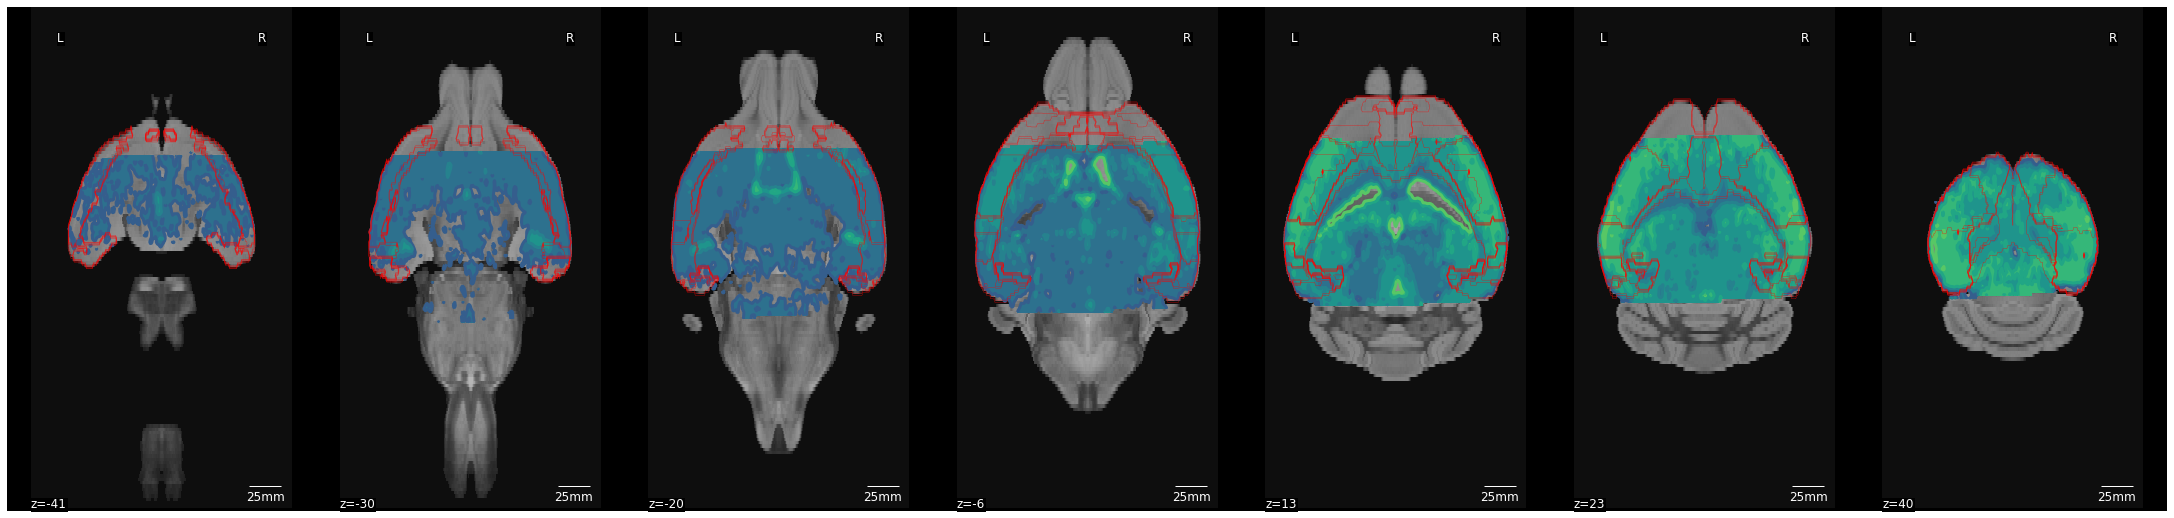

In [19]:
fig = plt.figure(figsize=(30,7))
dis = plot_anat(scaled_template_reor, cut_coords=7, display_mode='z', figure=fig)
dis.add_contours(warped_T1_path ,levels=[10,15,20,25], linewidths=3., filled=True)
dis.add_contours(scaled_labels_reor, linewidths=0.3, colors='r')
dis.annotate(scalebar=True, scale_size=25, scale_units='mm')

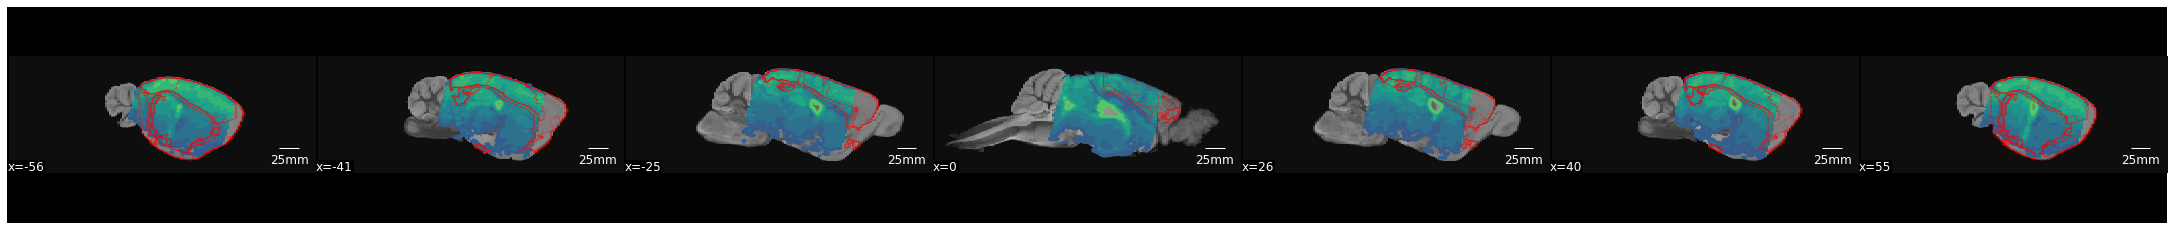

In [20]:
fig = plt.figure(figsize=(30,3))
dis = plot_anat(scaled_template_reor, cut_coords=7, display_mode='x', figure=fig)
dis.add_contours(warped_T1_path ,levels=[10,15,20,25], linewidths=3., filled=True)
dis.add_contours(scaled_labels_reor, linewidths=0.3, colors='r')
dis.annotate(scalebar=True, scale_size=25, scale_units='mm')

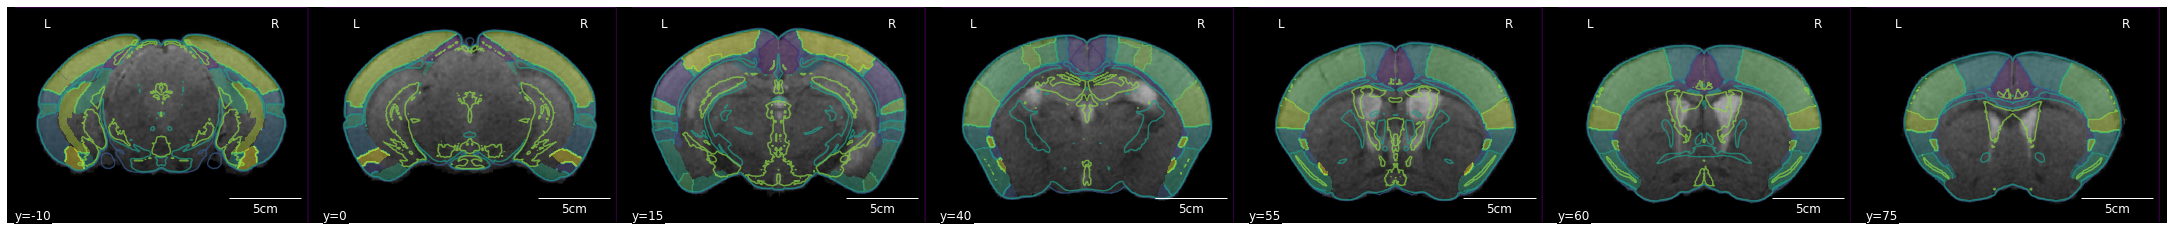

In [21]:
fig_1 = plt.figure(figsize=(30,3))
display = plot_anat(warped_T1, display_mode='y', cut_coords=[-10, 0, 15, 40, 55, 60, 75], figure=fig_1)
#display.add_contours(mean_img(epi_img), colors='b', alpha=0.5, linewidth=3.)
#display.add_contours(brain, colors='g')
display.add_contours(scaled_template_reor, levels=np.linspace(3,scaled_template_reorded.dataobj.max(),5), alpha=0.7)
display.add_contours(scaled_labels_reor, filled=True, alpha=0.36)
#display.add_contours(template_resamp, colors='r', linewidth=1.)
display.annotate(scalebar=True)

In [22]:
btr = fsl.BET()
btr.inputs.in_file = epi_path
btr.inputs.out_file = 'epi_brain.nii.gz'
btr.run()

In [23]:
epi_brain_path = 'epi_brain.nii.gz'

In [24]:
reg = RegistrationSynQuick()
reg.inputs.fixed_image = warped_T1_path
reg.inputs.moving_image = epi_brain_path
reg.inputs.num_threads = 6
reg.run()

201221-04:53:52,925 nipype.interface INFO:
	 stdout 2020-12-21T04:53:52.924870:
201221-04:53:52,926 nipype.interface INFO:
	 stdout 2020-12-21T04:53:52.924870:--------------------------------------------------------------------------------------
201221-04:53:52,927 nipype.interface INFO:
	 stdout 2020-12-21T04:53:52.924870: Mapping parameters
201221-04:53:52,928 nipype.interface INFO:
	 stdout 2020-12-21T04:53:52.924870:--------------------------------------------------------------------------------------
201221-04:53:52,928 nipype.interface INFO:
	 stdout 2020-12-21T04:53:52.924870: ANTSPATH is /usr/lib/ants
201221-04:53:52,929 nipype.interface INFO:
	 stdout 2020-12-21T04:53:52.924870:
201221-04:53:52,930 nipype.interface INFO:
	 stdout 2020-12-21T04:53:52.924870: Dimensionality:           3
201221-04:53:52,931 nipype.interface INFO:
	 stdout 2020-12-21T04:53:52.924870: Output name prefix:       transform
201221-04:53:52,931 nipype.interface INFO:
	 stdout 2020-12-21T04:53:52.924870:

In [25]:
outputs = reg.aggregate_outputs()
print(outputs)


forward_warp_field = /data/fMRI/transform1Warp.nii.gz
inverse_warp_field = /data/fMRI/transform1InverseWarp.nii.gz
inverse_warped_image = /data/fMRI/transformInverseWarped.nii.gz
out_matrix = /data/fMRI/transform0GenericAffine.mat
warped_image = /data/fMRI/transformWarped.nii.gz



In [26]:
epi_warped = outputs.warped_image

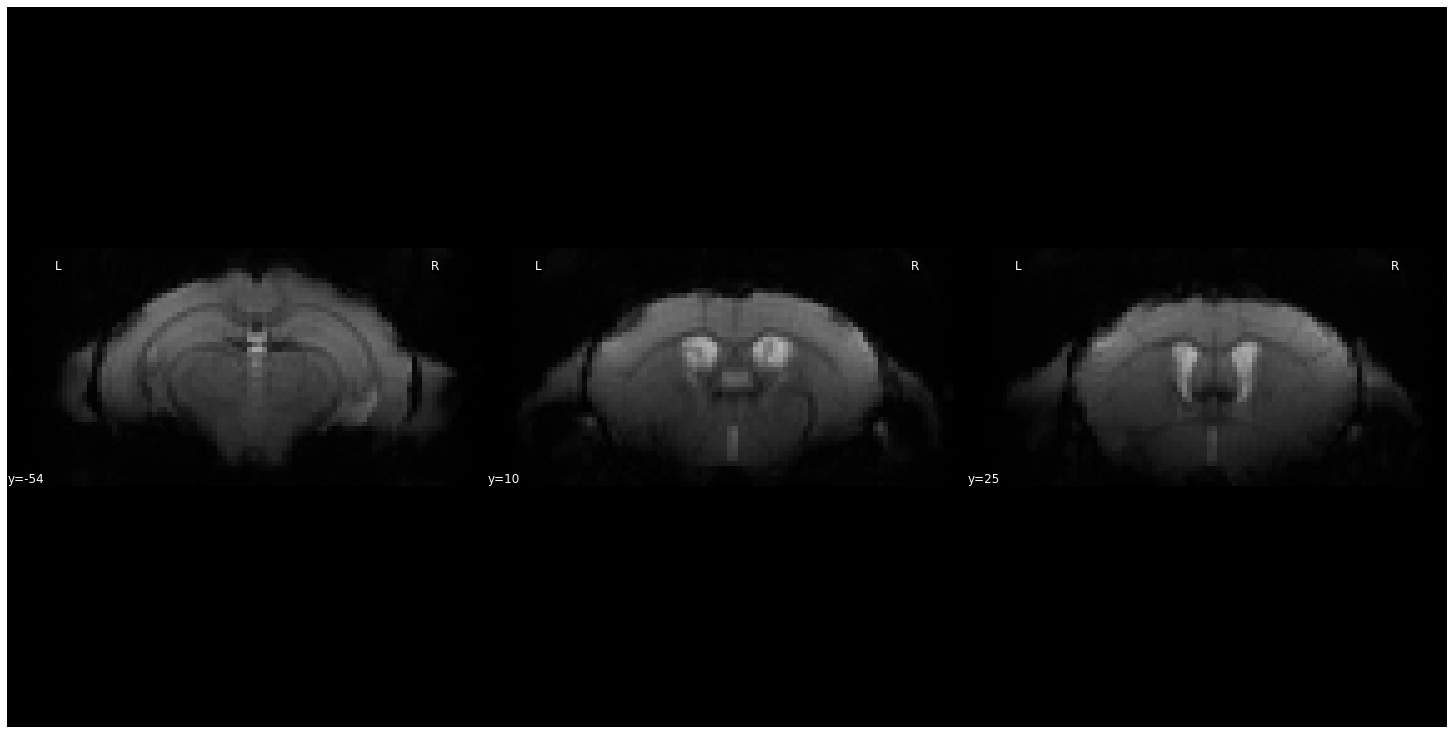

In [8]:
figure = plt.figure(figsize=(20,10))
d = plot_anat(mean_img('/data/testDS/mouse_main/bids/output/workingdir/dataPrep/_run_5_subject_id_01_task_name_4W/mcflirt_func/sub-01_ses-20201203_ATLAS_task-4W_acq-EPI_run-5_bold_roi_mcf.nii.gz'), display_mode='y', cut_coords=[-54, 10, 25],figure=figure)
#d.a

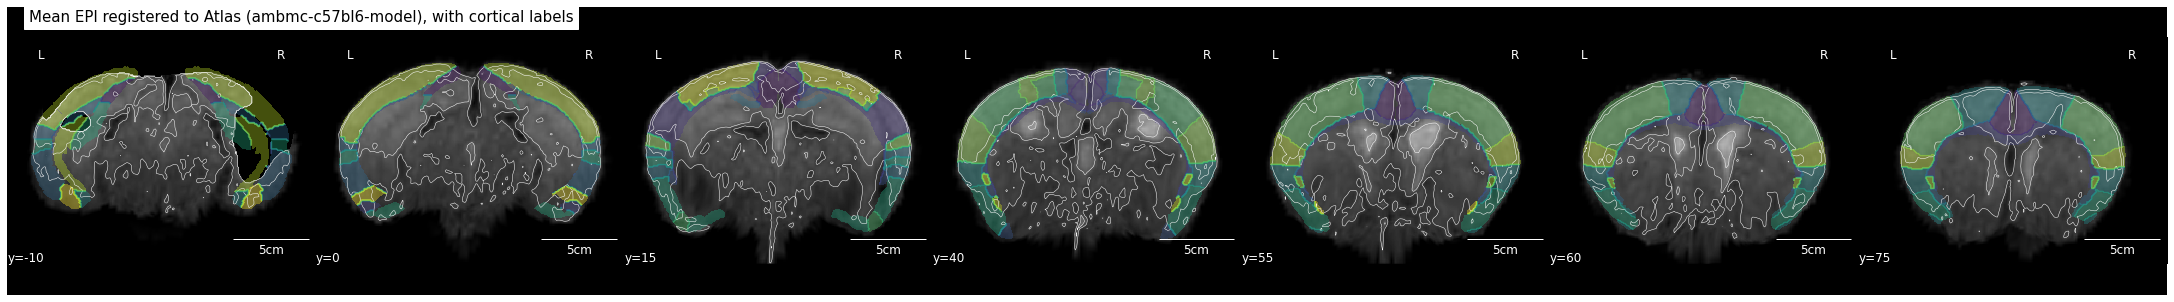

In [28]:
fig_1 = plt.figure(figsize=(30,4))

display = plot_anat(epi_warped, display_mode='y', cut_coords=[-10, 0, 15, 40, 55, 60, 75], figure=fig_1)
#display.add_contours(mean_img(epi_notgood_warped), colors='b', alpha=0.5, linewidth=3.)
display.add_contours(warped_T1_path, colors='w', linewidths=0.5, levels=[10,15,25])
#display.add_contours(scaled_template_reor, levels=np.linspace(3,scaled_template_reorded.dataobj.max(),5), alpha=0.7)
display.add_contours(scaled_labels_reor, filled=True, alpha=0.36)
#display.add_contours(template_resamp, colors='r', linewidth=1.)
display.annotate(scalebar=True)
display.title('Mean EPI registered to Atlas (ambmc-c57bl6-model), with cortical labels')

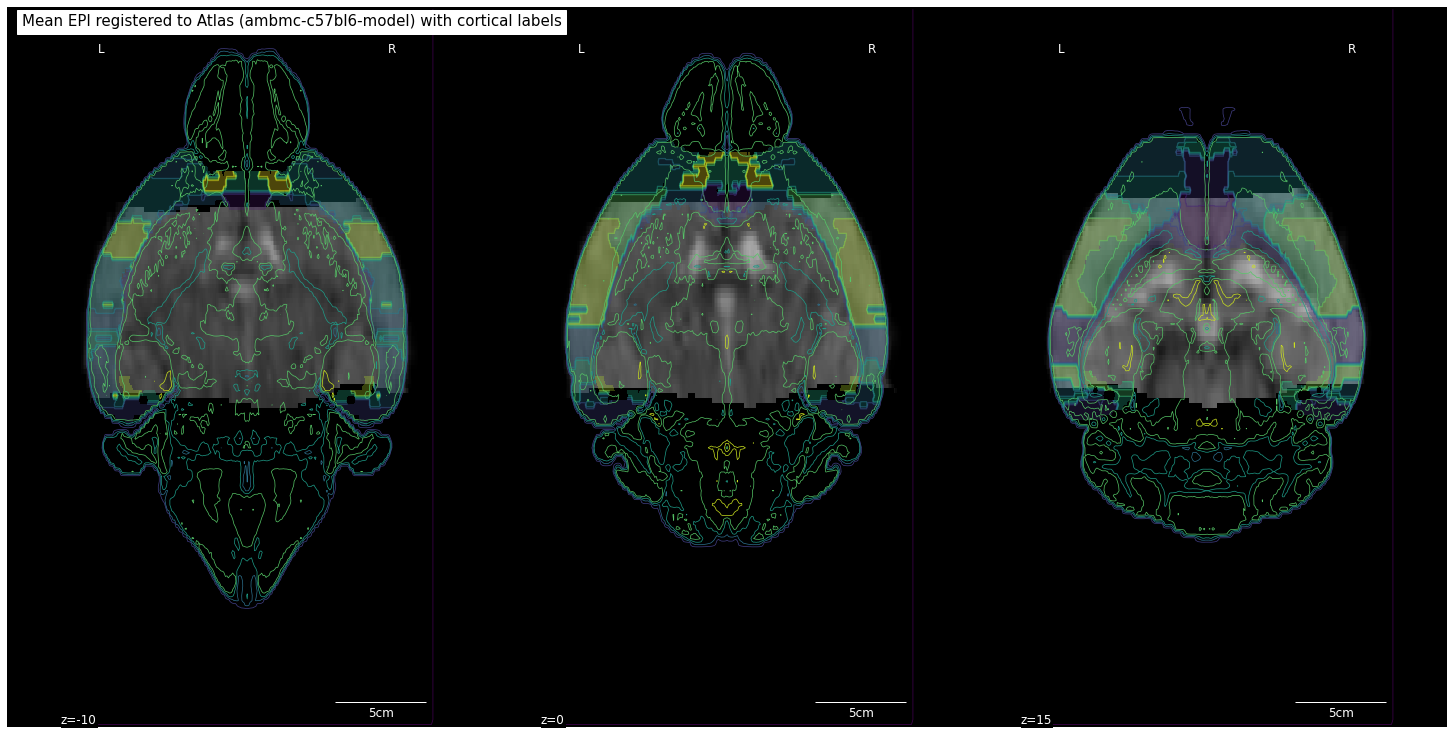

In [29]:
fig_2 = plt.figure(figsize=(20,10))

display = plot_anat(epi_warped, display_mode='z', cut_coords=[-10, 0, 15], figure=fig_2)
#display.add_contours(mean_img(epi_img), colors='b', alpha=0.5, linewidth=3.)
#display.add_contours(warped_T1_path, colors='w', linewidths=0.5, levels=[10,15,25])
display.add_contours(scaled_template_reor, linewidths=0.7, levels=np.linspace(3,scaled_template_reorded.dataobj.max(),7), alpha=1)
display.add_contours(scaled_labels_reor, filled=True, alpha=0.3)
#display.add_contours(template_resamp, colors='r', linewidth=1.)
display.annotate(scalebar=True)
display.title('Mean EPI registered to Atlas (ambmc-c57bl6-model) with cortical labels')

In [30]:
from xml.dom import minidom
# parse an xml file by name
mydoc = minidom.parse(labels_xml_path)
items = mydoc.getElementsByTagName('label')

print(f'number of labels = {len(items[1:])}')

number of labels = 74


In [31]:
labels = []
for i in range(len(items)):
    labels.append(items[i].firstChild.data)

In [32]:
from nipype.interfaces.nilearn import SignalExtraction
seinterface = SignalExtraction()
seinterface.inputs.in_file = epi_path
seinterface.inputs.label_files = scaled_labels_reor
segments = labels[1:5]
seinterface.inputs.class_labels = segments
seinterface.run()

ValueError: The length of class_labels ['A24a', "A24a'", 'A24b', "A24b'"] does not match the number of regions 74.0 found in label_files ['/data/testDS/scaled_labels.nii.gz']